In [7]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit_cst_pro as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [8]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 0.01, 900]


times = np.linspace(20, 90, 71)

df = pd.read_csv('2017-03-16_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[:71,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((71,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [9]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [10]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 3
New dimension: 7


Create uniform log prior

In [11]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 0.00001
prior_arr_upper[1] = 0.1
prior_arr_lower[2] = 1
prior_arr_upper[2] = 4000
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_88319/3449605926.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [12]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     492     0:01.2
2     945     0:02.5
3     1422    0:03.8
20    7608    0:17.9
40    13989   0:33.2
60    19242   0:46.7
80    24765   1:00.6
100   29922   1:13.7
120   35328   1:27.2
140   40533   1:40.3
160   46224   1:54.9
180   51975   2:09.4
200   57714   2:23.9
220   63222   2:37.7
240   68733   2:51.3
260   74226   3:05.1
280   79752   3:19.0
300   85473   3:33.1
320   91044   3:47.2
340   96516   4:00.4
360   102360   4:14.7
380   107916   4:29.2
400   113466   4:43.0
420   118917   4:56.5
440   124344   5:10.2
460   129993   5:24.6
480   135573   5:39.2
500   141093   5:52.8
520   146721   6:07.0
540   152145   6:21.2
560   157815   6:35.5
580   163518   6:49.9
600   169296   7:04.2
620   174702   7:18.0
640   180465   7:32.4
660   186054   7:46.7
680   192000   8:02.0
700   197838   8:16.7
720   203715   8:31.8
740   209277   8:46.1
760   215265   9:

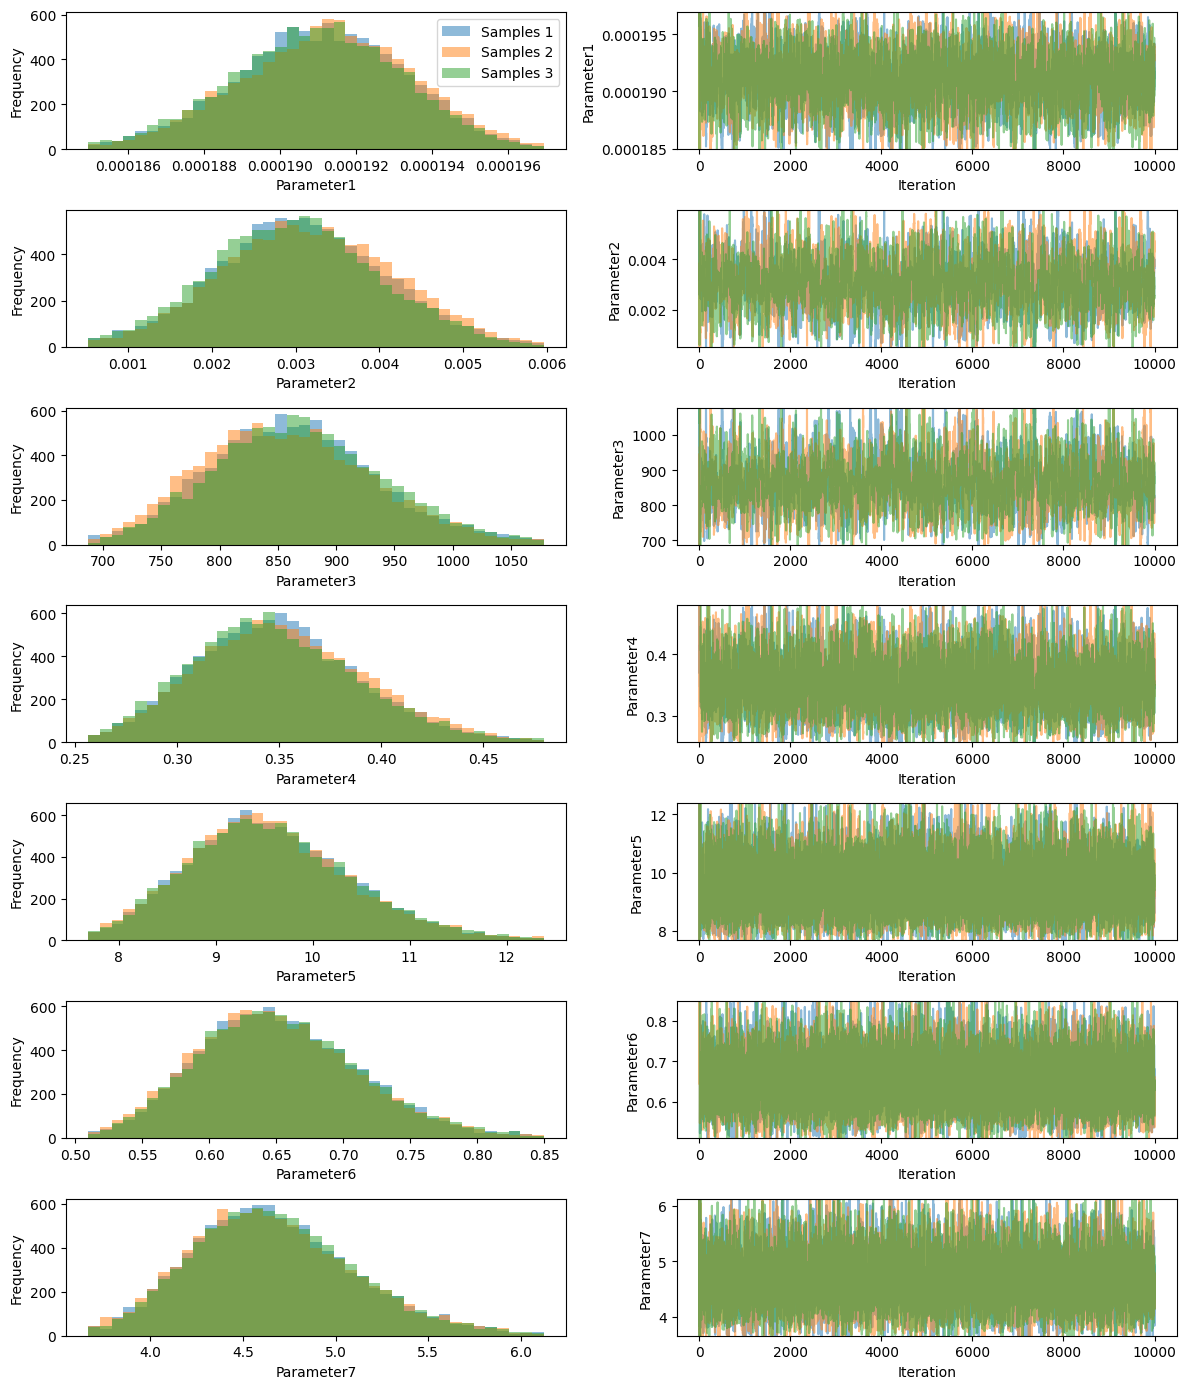

In [13]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [14]:

y0 = np.array([0.0003, 0.01, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.01, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.001, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.01, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.001, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.01, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.001, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.001, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)


Estimated parameters:
[1.91275901e-04 3.11720342e-03 8.53718440e+02 3.44273824e-01
 9.26853630e+00 6.38190765e-01 4.52314326e+00]
Estimated parameters:
[1.91275898e-04 3.11720210e-03 8.53718547e+02 3.44273753e-01
 9.26853692e+00 6.38190751e-01 4.52314362e+00]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pints/_optimisers/_xnes.py:82: UserWarning: All points requested by XNES are outside the boundaries.
  warnings.warn(


Estimated parameters:
[1.91275901e-04 3.11720291e-03 8.53718482e+02 3.44273801e-01
 9.26853648e+00 6.38190755e-01 4.52314345e+00]
Estimated parameters:
[1.91275899e-04 3.11720247e-03 8.53718520e+02 3.44273782e-01
 9.26853661e+00 6.38190766e-01 4.52314381e+00]
Estimated parameters:
[1.91275899e-04 3.11720274e-03 8.53718490e+02 3.44273790e-01
 9.26853662e+00 6.38190785e-01 4.52314356e+00]
Estimated parameters:
[2.64438207e-04 6.25848468e-03 5.57697735e+02 8.98951439e+00
 2.92358384e+01 2.17295616e+01 3.58753728e+01]
Estimated parameters:
[1.91275899e-04 3.11720202e-03 8.53718531e+02 3.44273777e-01
 9.26853703e+00 6.38190812e-01 4.52314361e+00]
Estimated parameters:
[2.10213691e-04 3.91412194e-03 7.85058624e+02 1.05108833e+00
 2.68422952e+01 4.57969592e+00 2.49804304e+00]


In [15]:
print(log_likelihood([1.91275899e-04, 3.11720293e-03, 8.53718500e+02, 3.44273769e-01,
 9.26853687e+00, 6.38190763e-01, 4.52314371e+00]))

AIC = 2*7 - 2*log_likelihood([1.91275899e-04, 3.11720293e-03, 8.53718500e+02, 3.44273769e-01,
 9.26853687e+00, 6.38190763e-01, 4.52314371e+00])

print(AIC)

-560.6267079036027
1135.2534158072053


In [16]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(9900, 7)
[1.93804664e-04 4.64033049e-03 7.35662780e+02 3.72349946e-01
 9.69377390e+00 6.90908600e-01 4.32201764e+00]
[[1.93804664e-04 4.64033049e-03 7.35662780e+02 ... 9.69377390e+00
  6.90908600e-01 4.32201764e+00]
 [1.94436599e-04 4.56425363e-03 7.46084910e+02 ... 9.83888311e+00
  6.18683123e-01 4.36947292e+00]
 [1.93881078e-04 4.75948400e-03 7.71563063e+02 ... 9.36882741e+00
  5.83017607e-01 4.47983687e+00]
 ...
 [1.91128116e-04 3.99690211e-03 7.85161485e+02 ... 9.93427961e+00
  6.30148933e-01 4.38955736e+00]
 [1.91236326e-04 3.78037492e-03 8.20954636e+02 ... 8.92727267e+00
  6.28036058e-01 3.84293593e+00]
 [1.93132924e-04 3.65559026e-03 8.26377314e+02 ... 9.91569841e+00
  6.38475197e-01 4.92913864e+00]]


In [17]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


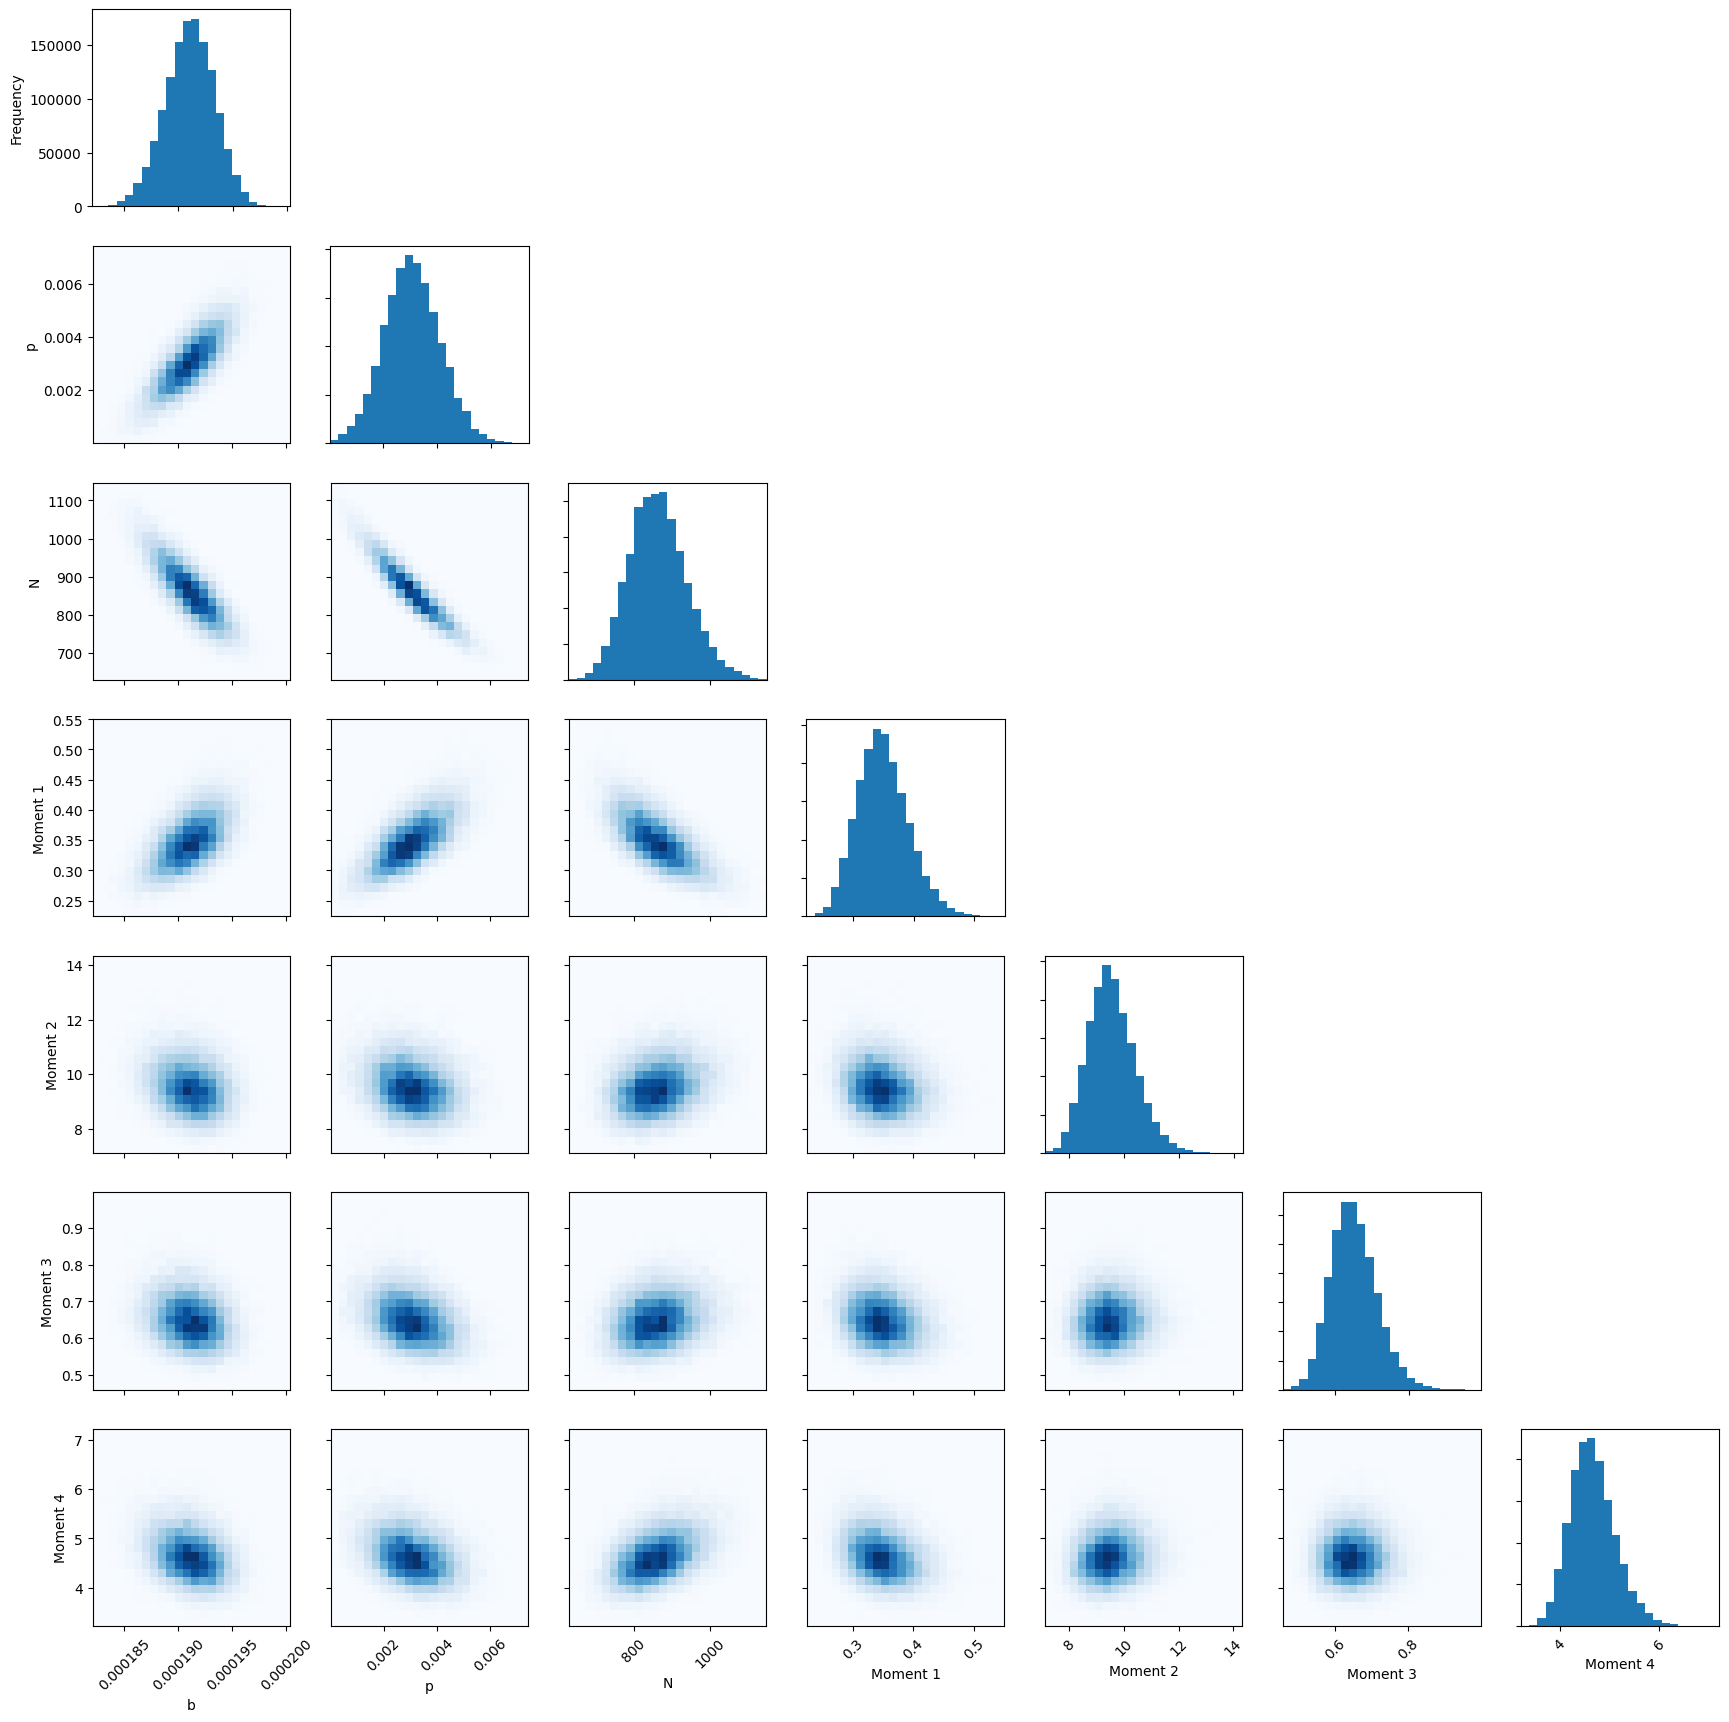

In [18]:


parameter_names = ["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

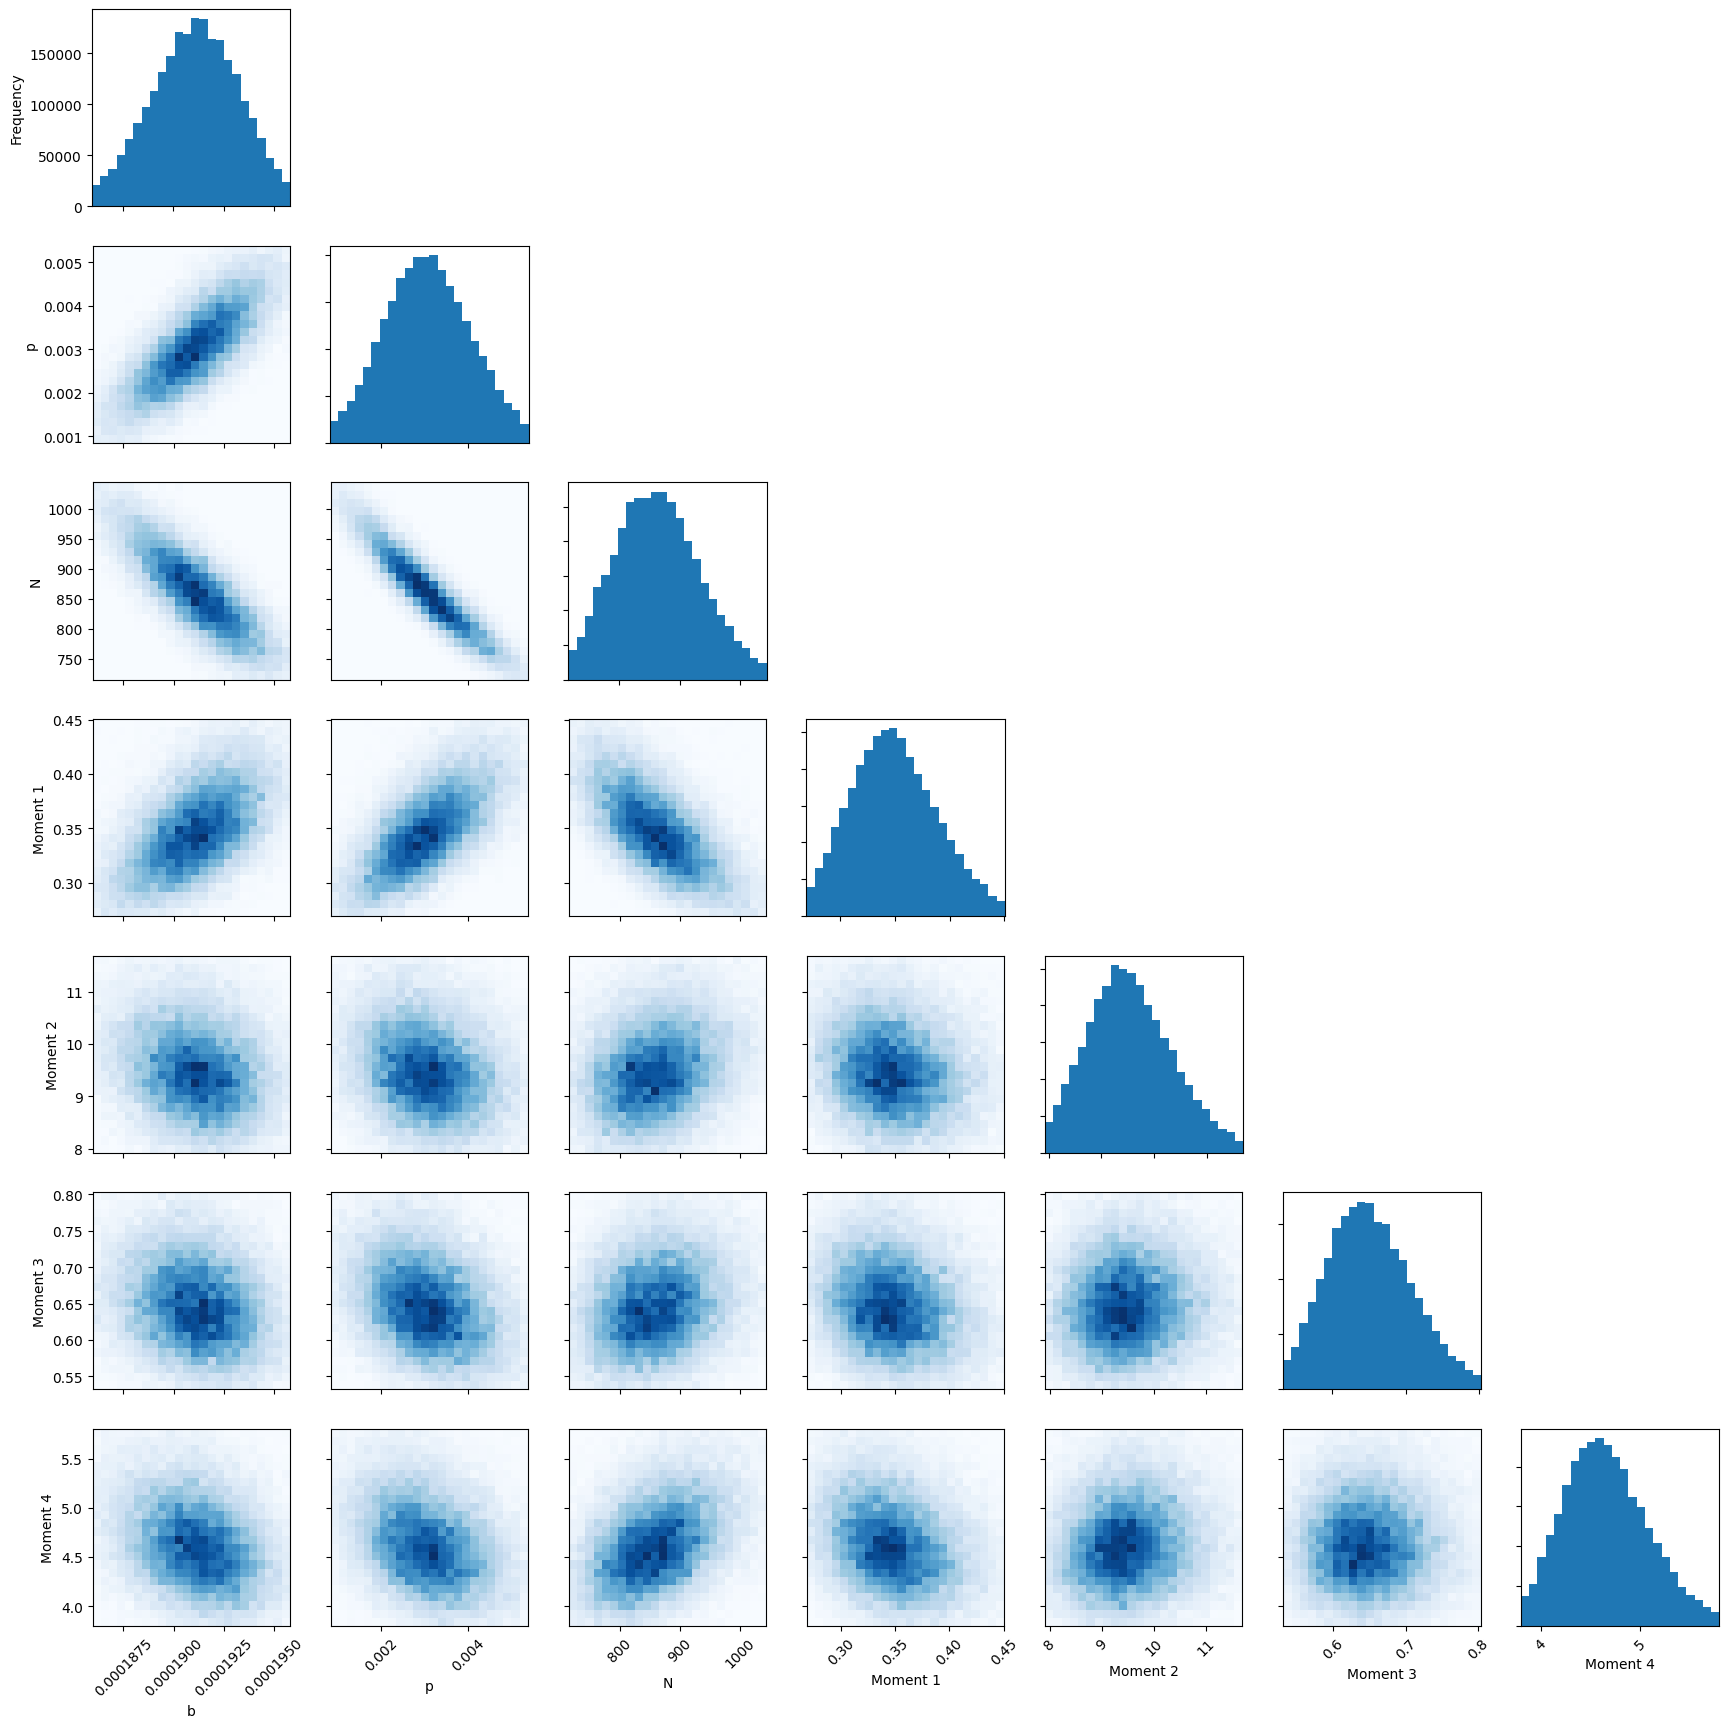

In [19]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

In [21]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess      ess per sec.
--------  ------  ------  ------  ------  ------  ------  -------  ------  -------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.00    802.50   0.11
p         0.00    0.00    0.00    0.00    0.00    0.00    0.01     1.00    629.10   0.09
N         863.67  76.15   726.16  809.49  860.84  913.06  1024.96  1.00    579.85   0.08
Moment 1  0.35    0.04    0.28    0.32    0.35    0.38    0.44     1.00    1061.31  0.15
Moment 2  9.56    0.86    8.06    8.96    9.50    10.10   11.43    1.00    3549.74  0.49
Moment 3  0.65    0.06    0.54    0.61    0.65    0.69    0.78     1.00    3212.22  0.45
Moment 4  4.66    0.46    3.86    4.34    4.62    4.94    5.67     1.00    2118.80  0.30


In [22]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [23]:

parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%      50%       75%       97.5%     rhat    ess       ess per sec.
--------  --------  --------  --------  -------  --------  --------  --------  ------  --------  --------------
b         0.000191  2.31e-06  0.000186  0.00019  0.000191  0.000193  0.000195  1       803       0.112
p         0.00308   0.00105   0.00106   0.00235  0.00305   0.00379   0.00517   1       629       0.0876
N         864       76.1      726       809      861       913       1.02e+03  1       580       0.0807
Moment 1  0.35      0.0421    0.276     0.32     0.348     0.377     0.439     1       1.06e+03  0.148
Moment 2  9.56      0.864     8.06      8.96     9.5       10.1      11.4      1       3.55e+03  0.494
Moment 3  0.652     0.0617    0.542     0.608    0.648     0.691     0.785     1       3.21e+03  0.447
Moment 4  4.66      0.459     3.86      4.34     4.62      4.94      5.67      1       2.12e+03  0.295


In [27]:
import math
print(math.log(4))
results.mean()

print(len(results.mean()))

AIC = 2*len(results.mean()) - 2*log_likelihood(results.mean())

print(AIC)


BIC = len(results.mean())*math.log(4) - 2*log_likelihood(results.mean())

print(BIC)

1.3862943611198906
7
1135.6768495716783
1131.3809100995175


In [29]:
shape_chains = np.shape(AllChains)
print(shape_chains)
DIC_1 = 0
for i in range(shape_chains[0]):
    thetas = AllChains[i,:]
    DIC_1 += -2*log_likelihood(thetas)

DIC_1 = DIC_1/shape_chains[0]

DIC_2 = -2*log_likelihood(results.mean())

DIC = 2*DIC_1 - DIC_2

print(DIC)

(29700, 7)
1135.2451333403847


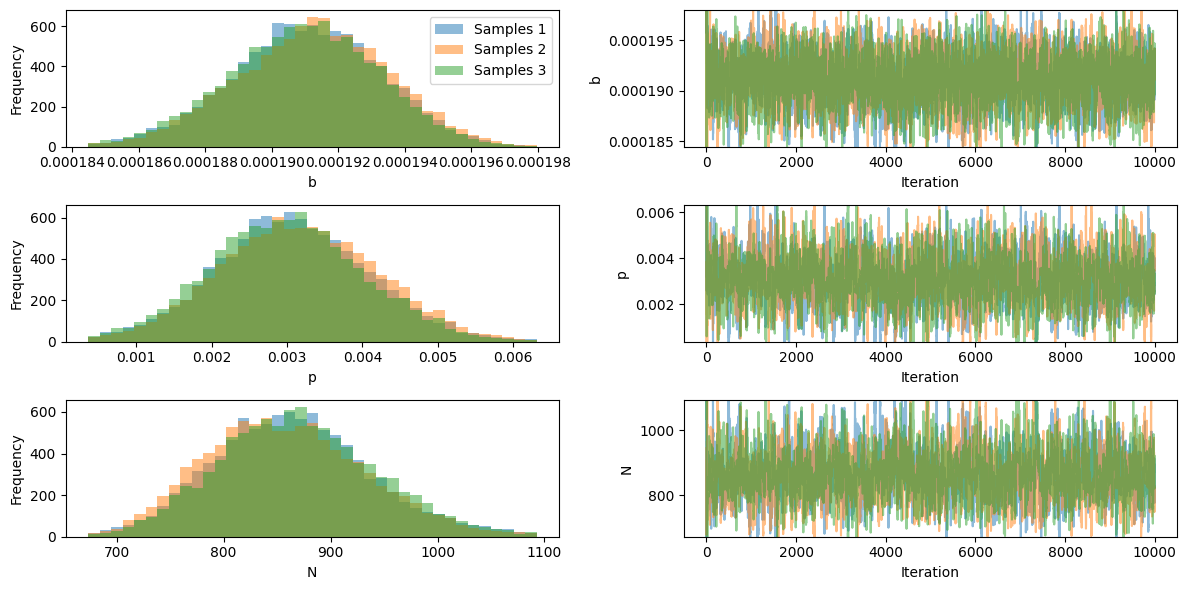

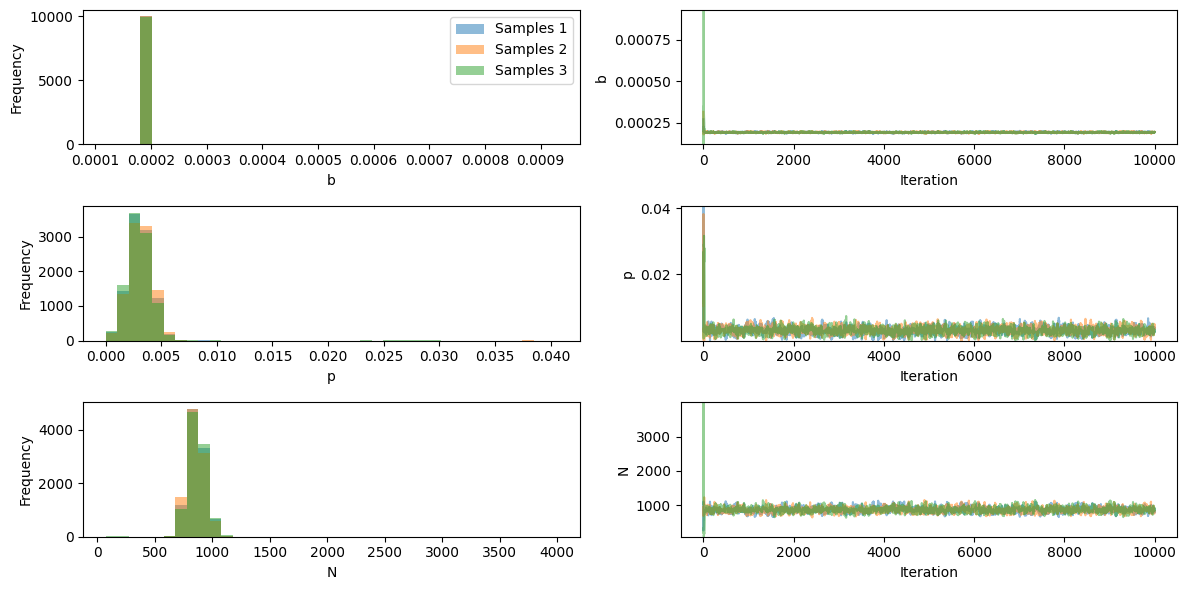

In [24]:
pints.plot.trace(chains[:,:,[0,1,2]], n_percentiles=99.5, parameter_names=["b","p","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1,2]], parameter_names=["b","p","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()

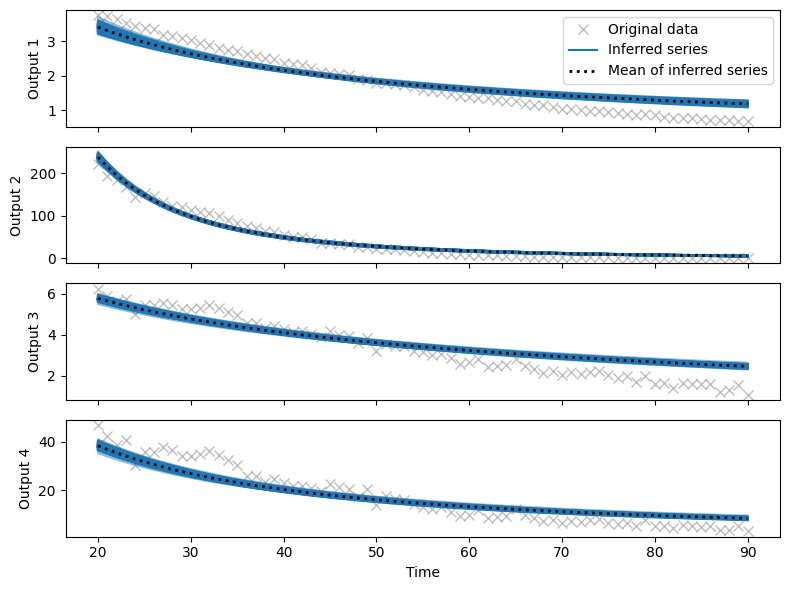

In [25]:
fig, axes = pints.plot.series(AllChains, problem)

# # Customise the plot, and add the original, noise-free data
# fig.set_size_inches(12,4.5)
# plt.plot(times, org_values, c='orange', label='Noise-free data')
# plt.legend()
# plt.show()

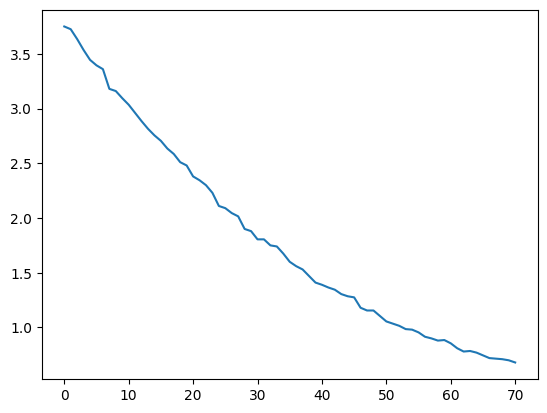

In [26]:

data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):

plt.plot(data_mean)